In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
%matplotlib inline
!pwd

/Users/apple/PycharmProjects/TianChi/o2o


In [2]:
# 数据加载
dir_file = 'ccf_o2o_tianchi'
offline = pd.read_csv(os.path.join(dir_file, 'ccf_offline_stage1_train.csv'))
print('data read end.')

data read end.


In [3]:
#格式化时间
offline['Date'] = pd.to_datetime(offline.Date, format='%Y%m%d')
offline['Date_received'] = pd.to_datetime(offline.Date_received, format='%Y%m%d')

X = offline.copy()
X.Distance.fillna(-1, inplace=True)  #将无距离信息设置为-1
X.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


## 提取线下有优惠券的用户信息

In [4]:
coupon_id_notnull = offline[offline.Coupon_id.notnull()] #有优惠券数据
temp = coupon_id_notnull
coupon_consume = temp[temp.Date.notnull()] #有优惠券并消费
coupon_no_consume = temp[temp.Date.isnull()] #有优惠券未消费
len(offline.User_id.unique())

539438

### 有优惠券并消费 coupon_consume_ranking

In [5]:
user_coupon_consume = coupon_consume.groupby('User_id')
temp = user_coupon_consume.size().to_frame('amount_coupon_consume')
df_user = temp.copy()
df_user.head()
print(df_user.shape)

(46395, 1)


In [6]:
temp['amount_coupon_consume'].value_counts()

1      32597
2       8579
3       2466
4       1103
5        561
6        313
7        203
8        118
9        111
10        63
11        48
12        46
13        34
15        19
16        15
14        14
17        13
18        12
23         9
24         9
21         8
19         7
27         7
25         5
22         4
26         4
28         3
34         2
35         2
30         2
40         2
41         2
20         2
71         1
38         1
73         1
93         1
36         1
113        1
54         1
118        1
56         1
33         1
29         1
32         1
Name: amount_coupon_consume, dtype: int64

In [7]:
def ranking(df, list_sorted=None, list_range=[1000, 2]):
    ret = df.copy()
    if list_sorted == None:
        list_range = ret.describe(percentiles=map(lambda x: x/list_range[0], range(1, list_range[0], list_range[1]))).iloc[4:-1]
        list_sorted = sorted(list(set(list_range.values.ravel().tolist())))
        print('divide into {} rank'.format(len(list_sorted)))
    for index, thresh in enumerate(list_sorted):
#         print(index, thresh)
        if index == 0:
            ret[df <= thresh]  = index
        else:
            ret[(df > list_sorted[index-1]) & (df <= thresh)] = index
    ret[df > thresh] = len(list_sorted)
    ret = ret.to_frame('ranking')
    return ret


In [8]:
# temp['amount_coupon_consume'].describe(percentiles=map(lambda x: x/1000, range(1, 1000, 2))).iloc[4:-1]
temp = ranking(temp['amount_coupon_consume']).rename(columns={'ranking':'amount_coupon_consume_ranking'})

divide into 13 rank


In [9]:
df_user = df_user.join(temp)
df_user.head()

,amount_coupon_consume,amount_coupon_consume_ranking
User_id,,
184,1,0
417,1,0
687,2,1
696,4,3
947,2,1


### 有优惠券未消费 coupon_no_consume_ranking

divide into 6 rank


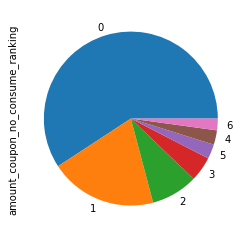

In [10]:
temp = coupon_no_consume.groupby('User_id').size().to_frame('amount_coupon_no_consume')
df_user1 = temp.copy()
temp = ranking(temp['amount_coupon_no_consume'], list_range=[100, 3]).rename(columns={'ranking':'amount_coupon_no_consume_ranking'})
df_user1 = df_user1.join(temp)
df_user1['amount_coupon_no_consume_ranking'].value_counts().plot.pie()

In [11]:
df_user = df_user.join(df_user1, how='outer')
df_user.head()
print(df_user.shape)

(510698, 4)


### 消费次数

In [12]:
#每个人优惠券总数
df_user['total_coupon'] = df_user['amount_coupon_consume'].fillna(0) + df_user['amount_coupon_no_consume'].fillna(0)
df_user = df_user.join(ranking(df_user['total_coupon']).rename(columns={'ranking':'total_coupon_ranking'}))
#优惠券使用比例
df_user['rate_coupon_consume'] = df_user['amount_coupon_consume'].fillna(0) / df_user['total_coupon']
df_user = df_user.join(ranking(df_user['rate_coupon_consume']).rename(columns={'ranking':'rate_coupon_consume_ranking'}))

divide into 14 rank
divide into 16 rank


In [13]:
df_user.rate_coupon_consume_ranking.value_counts()

0.0     464303
15.0     13470
11.0      9961
8.0       6096
6.0       4017
13.0      2732
5.0       2540
4.0       1605
10.0      1255
2.0       1223
1.0       1177
3.0       1040
14.0       652
7.0        583
9.0         27
12.0        17
Name: rate_coupon_consume_ranking, dtype: int64

### 没有用优惠券但进行消费

In [14]:
no_coupon_consume = offline[offline.Date.notna()]
temp = no_coupon_consume.groupby('User_id').size().to_frame('total_consume')
df_user = df_user.join(temp, how='outer')
df_user.head()
print(df_user.shape)

(539438, 9)


divide into 12 rank
(539438, 10)


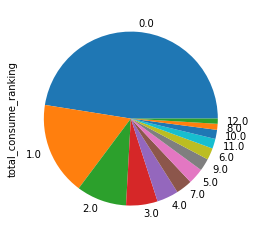

In [15]:
#消费总数（用优惠券和未用优惠券消费）
temp = ranking(df_user['total_consume'], list_range=[100, 2]).rename(columns={'ranking':'total_consume_ranking'})
temp.total_consume_ranking.value_counts().plot.pie()
df_user = df_user.join(temp)
print(df_user.shape)

In [16]:
#使用优惠券消费 与 所有消费 的 比值
temp = df_user['amount_coupon_consume'] / df_user['total_consume']
df_user['rate_total_coupon_consume'] = temp
print(df_user.shape)

(539438, 11)


divide into 10 rank
(539438, 12)


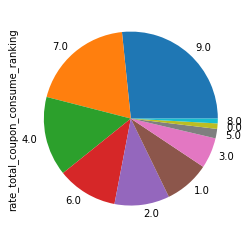

In [17]:
temp = ranking(df_user['rate_total_coupon_consume'], list_range=[100, 8]).rename(columns={'ranking':'rate_total_coupon_consume_ranking'})
temp['rate_total_coupon_consume_ranking'].value_counts().plot.pie()
df_user = df_user.join(temp)
print(df_user.shape)

In [18]:
df_user.head()

,amount_coupon_consume,amount_coupon_consume_ranking,amount_coupon_no_consume,amount_coupon_no_consume_ranking,total_coupon,total_coupon_ranking,rate_coupon_consume,rate_coupon_consume_ranking,total_consume,total_consume_ranking,rate_total_coupon_consume,rate_total_coupon_consume_ranking
User_id,,,,,,,,,,,,
4,NaN,NaN,2.0,1.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
35,NaN,NaN,4.0,3.0,4.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN
36,NaN,NaN,2.0,1.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
64,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
110,NaN,NaN,3.0,2.0,3.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN


### 消费时间平均间隔

In [19]:
# 用户所有消费时间平均间隔
temp = offline[offline.Date.notnull()].copy()
temp['_max'] = temp.groupby('User_id').Date.transform('max')
temp['_min'] = temp.groupby('User_id').Date.transform('min')
temp['_len'] = temp.groupby('User_id').Date.transform('count')
temp['total_consume_interval'] = (temp._max - temp._min).dt.days / (temp._len - 1)
temp.head()
# temp.unique()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,_max,_min,_len,total_consume_interval
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,2016-06-13,2016-02-17,3,58.5
5,1439408,2632,NaN,NaN,0.0,NaT,2016-05-16,2016-06-13,2016-02-17,3,58.5
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13,2016-06-13,2016-02-17,3,58.5
11,2029232,6459,NaN,NaN,0.0,NaT,2016-06-26,2016-06-26,2016-05-19,2,38.0
12,2029232,6459,NaN,NaN,0.0,NaT,2016-05-19,2016-06-26,2016-05-19,2,38.0


divide into 14 rank


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,_max,_min,_len,total_consume_interval,total_consume_interval_ranking
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,2016-06-13,2016-02-17,3,58.5,13.0
5,1439408,2632,NaN,NaN,0.0,NaT,2016-05-16,2016-06-13,2016-02-17,3,58.5,13.0
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13,2016-06-13,2016-02-17,3,58.5,13.0
11,2029232,6459,NaN,NaN,0.0,NaT,2016-06-26,2016-06-26,2016-05-19,2,38.0,13.0
12,2029232,6459,NaN,NaN,0.0,NaT,2016-05-19,2016-06-26,2016-05-19,2,38.0,13.0


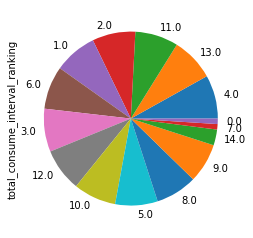

In [20]:
temp1 = ranking(temp['total_consume_interval'], list_range=[100 ,8]).rename(columns={'ranking':'total_consume_interval_ranking'})
temp = temp.join(temp1)
temp1.total_consume_interval_ranking.value_counts().plot.pie()
temp.head()

In [21]:
df_user = df_user.join(temp.drop_duplicates('User_id').set_index('User_id')[['total_consume_interval', 'total_consume_interval_ranking']])
df_user.head()
print(df_user.shape)

(539438, 14)


In [22]:
# temp.set_index('User_id')[['total_consume_interval', 'total_consume_interval_ranking']]

divide into 14 rank


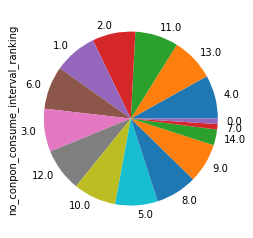

In [23]:
#用户没有用优惠券但消费 平均时间间隔
temp = no_coupon_consume.copy()
tmp = temp.groupby('User_id').Date
temp['_max'] = tmp.transform('max')
temp['_min'] = tmp.transform('min')
temp['_count'] = tmp.transform('count')
temp['no_conpon_consume_interval'] = (temp._max - temp._min).dt.days / (temp._count - 1)
temp1 = ranking(temp['no_conpon_consume_interval'], list_range=[100, 8]).rename(columns={'ranking':'no_conpon_consume_interval_ranking'})
temp1.no_conpon_consume_interval_ranking.value_counts().plot.pie()
temp = temp.join(temp1)

In [24]:
# temp.head()
df_user = df_user.join(temp.drop_duplicates('User_id').set_index('User_id')[['no_conpon_consume_interval', 'no_conpon_consume_interval_ranking']])
df_user.head()
print(df_user.shape)

(539438, 16)


divide into 14 rank


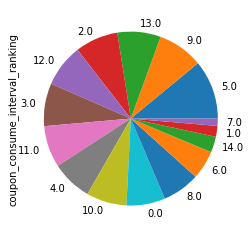

In [25]:
#用户优惠券消费平均间隔
temp = coupon_consume.copy()
temp1 = temp.groupby('User_id').Date
temp['_max'] = temp1.transform('max')
temp['_min'] = temp1.transform('min')
temp['_count'] = temp1.transform('count')
temp['coupon_consume_interval'] = (temp._max - temp._min).dt.days / (temp._count - 1)
temp = temp.join(ranking(temp['coupon_consume_interval'], list_range=[100, 8]).rename(columns={'ranking':'coupon_consume_interval_ranking'}))
temp.coupon_consume_interval_ranking.value_counts().plot.pie()


In [26]:
df_user = df_user.join(temp.drop_duplicates('User_id').set_index('User_id')[['coupon_consume_interval', 'coupon_consume_interval_ranking']])
df_user.head()
print(df_user.shape)

(539438, 18)


divide into 17 rank


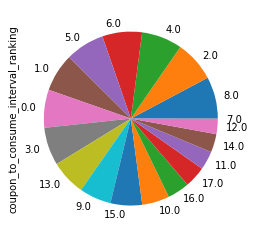

In [27]:
#用户优惠券领取到使用到平均间隔
temp = coupon_consume.copy()
temp['days'] = (temp.Date - temp.Date_received).dt.days
temp = (temp.groupby('User_id').days.sum() / temp.groupby('User_id').size()).to_frame('coupon_to_consume_interval')
temp = temp.join(ranking(temp['coupon_to_consume_interval'], list_range=[100 ,5]).rename(columns={'ranking':'coupon_to_consume_interval_ranking'}))
# temp.drop_duplicates('User_id', inplace=True)
temp.coupon_to_consume_interval_ranking.value_counts().plot.pie()
# temp.head()

In [28]:
df_user = df_user.join(temp)
df_user.head()
print(df_user.shape)

(539438, 20)


### 折扣转换

In [29]:
# 1. 将满xx减yy类型(`xx:yy`)的券变成折扣率 : `1 - yy/xx`，同时建立折扣券相关的特征 
# `discount_rate, discount_man, discount_jian, discount_type`
# 2. 将距离 `str` 转为 `int`
# convert Discount_rate and Distance

def getDiscountType(row):
    if pd.isnull(row):
        return np.nan
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    if pd.isnull(row):
        return 1.0
    elif ':' in str(row):
        rows = str(row).split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in str(row):
        rows = str(row).split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in str(row):
        rows = str(row).split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    #测试集出现了500:30在训练集中没有
#     df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
#     df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    return df

X = processData(X)
X.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_type
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,1.000000,NaN
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,0.866667,1.0
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,0.950000,1.0
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,0.950000,1.0
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,0.950000,1.0


### label 小于15天消费为1

In [30]:
X['label'] = 0
X['label'][(X.Date - X.Date_received).dt.days < 15] = 1
X.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_type,label
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,1.000000,NaN,0
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,0.866667,1.0,0
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,0.950000,1.0,0
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,0.950000,1.0,0
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,0.950000,1.0,0


### 商家信息

In [31]:
#商家销售次数
df_mer = offline[offline.Date.notna()].groupby('Merchant_id').size().to_frame('mer_sell')
df_mer = df_mer.join(ranking(df_mer['mer_sell'], list_range=[100, 5]).rename(columns={'ranking':'mer_sell_ranking'}))
df_mer.head()
print(df_mer.shape)

divide into 21 rank
(8321, 2)


In [32]:
len(offline.Merchant_id.unique())

8415

In [33]:
#商家优惠券核销次数
temp = coupon_consume.groupby('Merchant_id').size().to_frame('mer_sell_coupon')
temp = temp.join(ranking(temp['mer_sell_coupon'], list_range=[100, 5]).rename(columns={'ranking':'mer_sell_coupon_ranking'}))
df_mer = df_mer.join(temp, how='outer')
df_mer.head()
print(df_mer.shape)

divide into 10 rank
(8321, 4)


divide into 9 rank


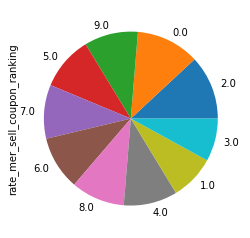

In [34]:
#商家优惠券核销占全部的比例
df_mer['rate_mer_sell_coupon'] = df_mer.mer_sell / df_mer.mer_sell_coupon
df_mer['rate_mer_sell_coupon_ranking'] = ranking(df_mer['rate_mer_sell_coupon'], list_range=[10, 1])['ranking']
df_mer['rate_mer_sell_coupon_ranking'].value_counts().plot.pie()

divide into 9 rank


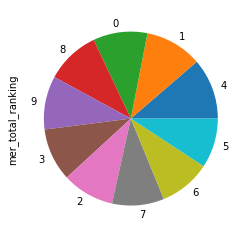

In [35]:
#商家在数据集中出现的次数
temp = offline.groupby('Merchant_id').size().to_frame('mer_total')
temp = temp.join(ranking(temp['mer_total'], list_range=[10, 1]).rename(columns={'ranking':'mer_total_ranking'}))
temp.mer_total_ranking.value_counts().plot.pie()

divide into 9 rank


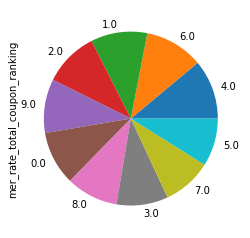

In [36]:
temp = df_mer.join(temp, how='outer')
#商家优惠券销售占出现次数比例
temp['mer_rate_total_coupon'] = temp.mer_sell_coupon / temp.mer_total
temp = temp.join(ranking(temp['mer_rate_total_coupon'], list_range=[10, 1]).rename(columns={'ranking':'mer_rate_total_coupon_ranking'}))
temp.mer_rate_total_coupon_ranking.value_counts().plot.pie()

In [37]:
df_mer = temp
print(df_mer.shape)

(8415, 10)


divide into 8 rank


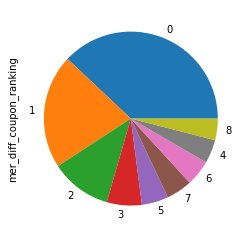

In [38]:
#商家优惠券核销的不同用户数量
temp = coupon_consume.groupby(['Merchant_id', 'User_id']).size()
temp = temp.groupby('Merchant_id').size().to_frame('mer_diff_coupon')
temp = temp.join(ranking(temp['mer_diff_coupon'], list_range=[100, 5]).rename(columns={'ranking':'mer_diff_coupon_ranking'}))
temp.mer_diff_coupon_ranking.value_counts().plot.pie()

In [39]:
df_mer = df_mer.join(temp, how='outer')
df_mer.head()
print(df_mer.shape)

(8415, 12)


divide into 9 rank


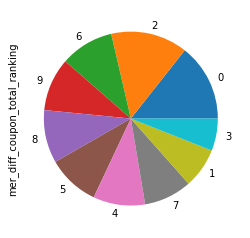

In [40]:
#商家优惠券领取的不同的用户数量
temp = offline[offline.Date_received.notna()].groupby(['Merchant_id', 'User_id']).size()
temp = temp.groupby('Merchant_id').size().to_frame('mer_diff_coupon_total')
temp = temp.join(ranking(temp.mer_diff_coupon_total, list_range=[10, 1]).rename(columns={'ranking':'mer_diff_coupon_total_ranking'}))
temp.mer_diff_coupon_total_ranking.value_counts().plot.pie()

In [41]:
df_mer = df_mer.join(temp, how='outer')
df_mer.head()
print(df_mer.shape)

(8415, 14)


divide into 9 rank


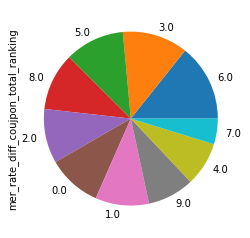

In [42]:
#核销商家优惠券的不同用户占领取的不同用户比重
temp = (df_mer.mer_diff_coupon / df_mer.mer_diff_coupon_total).to_frame('mer_rate_diff_coupon_total')
temp = temp.join(ranking(temp['mer_rate_diff_coupon_total'], list_range=[10, 1]).rename(columns={'ranking':'mer_rate_diff_coujpon_total_ranking'}))
temp.mer_rate_diff_coujpon_total_ranking.value_counts().plot.pie()

In [43]:
df_mer = df_mer.join(temp, how='outer')
df_mer.head()
print(df_mer.shape)

(8415, 16)


divide into 9 rank


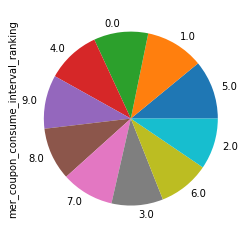

In [44]:
#商家优惠券被核销平均时间
temp = coupon_consume.copy()
temp1 = temp.groupby('Merchant_id').Date
temp['_max'] = temp1.transform('max')
temp['_min'] = temp1.transform('min')
temp['_count'] = temp1.transform('count')
temp['mer_coupon_consume_interval'] = (temp._max - temp._min).dt.days / (temp._count - 1)
temp.drop_duplicates('Merchant_id', inplace=True)
# temp.mer_coupon_consume_interval.value_counts()
temp = temp.join(ranking(temp.mer_coupon_consume_interval, list_range=[10, 1]).rename(columns={'ranking':'mer_coupon_consume_interval_ranking'}))
temp.mer_coupon_consume_interval_ranking.value_counts().plot.pie()

In [45]:
df_mer = df_mer.join(temp.set_index('Merchant_id').iloc[:, -2:], how='outer')
df_mer.head()
print(df_mer.shape)

(8415, 18)


### 用户信息和商家信息保存

In [46]:
list_usr_ranking = []
for i in df_user.columns.tolist():
    if i.endswith('ranking'):
        list_usr_ranking.append(i)
print(list_usr_ranking)

df_user = df_user[list_usr_ranking]
# df_user.to_csv('df_usr.csv',columns=list_usr_ranking)

['amount_coupon_consume_ranking', 'amount_coupon_no_consume_ranking', 'total_coupon_ranking', 'rate_coupon_consume_ranking', 'total_consume_ranking', 'rate_total_coupon_consume_ranking', 'total_consume_interval_ranking', 'no_conpon_consume_interval_ranking', 'coupon_consume_interval_ranking', 'coupon_to_consume_interval_ranking']


In [47]:
df_user.head()

,amount_coupon_consume_ranking,amount_coupon_no_consume_ranking,total_coupon_ranking,rate_coupon_consume_ranking,total_consume_ranking,rate_total_coupon_consume_ranking,total_consume_interval_ranking,no_conpon_consume_interval_ranking,coupon_consume_interval_ranking,coupon_to_consume_interval_ranking
User_id,,,,,,,,,,
4,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
list_mer_ranking = []
for i in df_mer.columns.tolist():
    if i.endswith('ranking'):
        list_mer_ranking.append(i)
print(list_mer_ranking)

# df_mer.to_csv('df_mer.csv', columns=list_mer_ranking)

['mer_sell_ranking', 'mer_sell_coupon_ranking', 'rate_mer_sell_coupon_ranking', 'mer_total_ranking', 'mer_rate_total_coupon_ranking', 'mer_diff_coupon_ranking', 'mer_diff_coupon_total_ranking', 'mer_rate_diff_coujpon_total_ranking', 'mer_coupon_consume_interval_ranking']


In [49]:
df_mer.head()

,mer_sell,mer_sell_ranking,mer_sell_coupon,mer_sell_coupon_ranking,rate_mer_sell_coupon,rate_mer_sell_coupon_ranking,mer_total,mer_total_ranking,mer_rate_total_coupon,mer_rate_total_coupon_ranking,mer_diff_coupon,mer_diff_coupon_ranking,mer_diff_coupon_total,mer_diff_coupon_total_ranking,mer_rate_diff_coupon_total,mer_rate_diff_coujpon_total_ranking,mer_coupon_consume_interval,mer_coupon_consume_interval_ranking
Merchant_id,,,,,,,,,,,,,,,,,,
1,14.0,10.0,NaN,NaN,NaN,NaN,14,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,3.0,NaN,NaN,NaN,NaN,11,3,NaN,NaN,NaN,NaN,7.0,4.0,NaN,NaN,NaN,NaN
3,9.0,7.0,1.0,0.0,9.0,4.0,18,4,0.055556,3.0,1.0,0.0,10.0,5.0,0.100000,2.0,NaN,NaN
4,38.0,16.0,5.0,4.0,7.6,4.0,40,6,0.125000,7.0,2.0,1.0,3.0,1.0,0.666667,9.0,2.5,1.0
5,54.0,18.0,3.0,2.0,18.0,7.0,79,8,0.037975,2.0,3.0,2.0,21.0,7.0,0.142857,3.0,2.5,1.0


In [50]:
temp = X.merge(df_mer[list_mer_ranking], on='Merchant_id', how='left')

In [51]:
# temp = temp.merge(df_user[list_usr_ranking], on='User_id', how='left')
temp = temp.merge(df_user, on='User_id', how='left')

In [52]:
temp.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_type,label,...,amount_coupon_consume_ranking,amount_coupon_no_consume_ranking,total_coupon_ranking,rate_coupon_consume_ranking,total_consume_ranking,rate_total_coupon_consume_ranking,total_consume_interval_ranking,no_conpon_consume_interval_ranking,coupon_consume_interval_ranking,coupon_to_consume_interval_ranking
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,1.000000,NaN,0,...,0.0,3.0,4.0,5.0,2.0,6.0,13.0,13.0,NaN,17.0
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,0.866667,1.0,0,...,0.0,3.0,4.0,5.0,2.0,6.0,13.0,13.0,NaN,17.0
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,0.950000,1.0,0,...,0.0,3.0,4.0,5.0,2.0,6.0,13.0,13.0,NaN,17.0
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,0.950000,1.0,0,...,0.0,3.0,4.0,5.0,2.0,6.0,13.0,13.0,NaN,17.0
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,0.950000,1.0,0,...,0.0,3.0,4.0,5.0,2.0,6.0,13.0,13.0,NaN,17.0


In [53]:
import xgboost as xgb

In [54]:
train_col = ['discount_rate', 'discount_type', 'mer_sell_ranking',
       'mer_sell_coupon_ranking', 'rate_mer_sell_coupon_ranking',
       'mer_total_ranking', 'mer_rate_total_coupon_ranking',
       'mer_diff_coupon_ranking', 'mer_diff_coupon_total_ranking',
       'mer_rate_diff_coujpon_total_ranking',
       'mer_coupon_consume_interval_ranking', 'amount_coupon_consume_ranking',
       'amount_coupon_no_consume_ranking', 'total_coupon_ranking',
       'rate_coupon_consume_ranking', 'total_consume_ranking',
       'rate_total_coupon_consume_ranking', 'total_consume_interval_ranking',
       'no_conpon_consume_interval_ranking', 'coupon_consume_interval_ranking',
       'coupon_to_consume_interval_ranking']

dtrain = xgb.DMatrix(temp[train_col].fillna(-1).iloc[:-2000], temp['label'].fillna(0).iloc[:-2000])
dtest = xgb.DMatrix(temp[train_col].fillna(-1).iloc[-2000:], temp['label'].fillna(0).iloc[-2000:]) 

In [55]:
params={}
params['eval_metric'] = 'auc'
# params={'booster':'gbtree',
# 	    'objective': 'rank:pairwise',
# 	    'eval_metric':'auc',
# 	    'gamma':0.1,
# 	    'min_child_weight':1.1,
# 	    'max_depth':5,
# 	    'lambda':10,
# 	    'subsample':0.7,
# 	    'colsample_bytree':0.7,
# 	    'colsample_bylevel':0.7,
# 	    'eta': 0.01,
# 	    'tree_method':'exact',
# 	    'seed':0,
# 	    'nthread':12
# 	    }
num_round = 10
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_round, evallist)

[14:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.9893	train-auc:0.988675
[14:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.990684	train-auc:0.989272
[14:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.990771	train-auc:0.989754
[14:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-auc:0.991172	train-auc:0.990078
[14:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-auc:0.991462	train-auc:0.9903
[14:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[5]	eval-auc:0.991628	train-auc:0.990428
[14:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes,

In [81]:
from sklearn.preprocessing import MinMaxScaler
ser_valid = temp[train_col].fillna(-1).iloc[-2000:]
ser_valid = xgb.DMatrix(ser_valid)
vpre = bst.predict(ser_valid)
temp_valid = temp.fillna(-1).iloc[-2000:]
vpred = MinMaxScaler(copy=True,feature_range=(0,1)).fit_transform(vpre.reshape(-1,1))
temp_valid['pred'] = vpre
temp_valid.head()

from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
#性能评价函数
def myauc(test):
    testgroup = test.groupby(['Coupon_id'])
    aucs = []
    for i in testgroup:
        tmpdf = i[1] 
        if len(tmpdf['label'].unique()) != 2:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred'], pos_label=1)
        aucs.append(auc(fpr,tpr))
    return np.average(aucs)


print(myauc(temp_valid))

train_pre = bst.predict(dtrain)
train_pred = MinMaxScaler(copy=True,feature_range=(0,1)).fit_transform(train_pre.reshape(-1,1))
temp_train = temp[['Coupon_id', 'label']][:-2000]
temp_train.label = temp_train.label.fillna(0)
temp_train['pred'] = train_pred
print(myauc(temp_train))

0.8811330561330561
0.9327508748554119


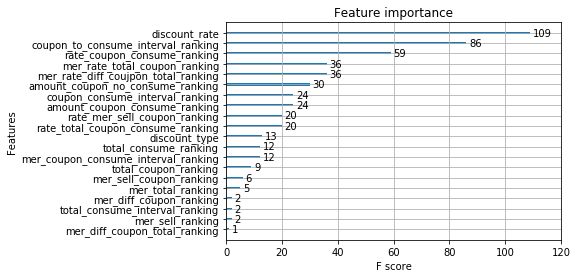

In [57]:
xgb.plot_importance(bst)

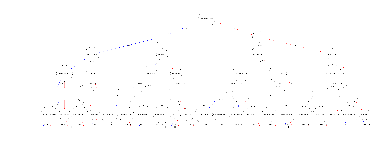

In [58]:
image = xgb.plot_tree(bst, num_trees=2)

In [59]:
image.figure.savefig('123.jpeg')

In [60]:
df_test = pd.read_csv(os.path.join(dir_file, 'ccf_offline_stage1_test_revised.csv'))

In [61]:
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


In [62]:
temp_test = processData(df_test)
temp_test = df_test.merge(df_mer, on='Merchant_id', how='left')
temp_test = temp_test.merge(df_user, on='User_id', how='left')
temp_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_type,mer_sell,mer_sell_ranking,...,amount_coupon_consume_ranking,amount_coupon_no_consume_ranking,total_coupon_ranking,rate_coupon_consume_ranking,total_consume_ranking,rate_total_coupon_consume_ranking,total_consume_interval_ranking,no_conpon_consume_interval_ranking,coupon_consume_interval_ranking,coupon_to_consume_interval_ranking
0,4129537,450,9983,30:5,1.0,20160712,0.833333,1,12285.0,21.0,...,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6949378,1300,3429,30:5,NaN,20160706,0.833333,1,219.0,20.0,...,0.0,NaN,0.0,15.0,1.0,7.0,1.0,1.0,NaN,3.0
2,2166529,7113,6928,200:20,5.0,20160727,0.900000,1,3487.0,21.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2166529,7113,1808,100:10,5.0,20160727,0.900000,1,3487.0,21.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,6172162,7605,6500,30:1,2.0,20160708,0.966667,1,1212.0,21.0,...,NaN,0.0,0.0,0.0,7.0,NaN,10.0,10.0,NaN,NaN


In [63]:
list_test = temp_test.columns.tolist()
list_train = temp.columns.tolist()

for i in train_col:
    if i not in list_test:
        print(i)

In [64]:
dpre = xgb.DMatrix(temp_test[train_col].fillna(-1))
ypre = bst.predict(dpre)

In [65]:
type(ypre)

numpy.ndarray

In [66]:
ypre.shape

(113640,)

In [67]:
df_pre = pd.DataFrame({'result': ypre})

In [68]:
df_pre = df_test.join(df_pre)
df_pre.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_type,result
0,4129537,450,9983,30:5,1.0,20160712,0.833333,1,0.014140
1,6949378,1300,3429,30:5,NaN,20160706,0.833333,1,0.970755
2,2166529,7113,6928,200:20,5.0,20160727,0.900000,1,0.014140
3,2166529,7113,1808,100:10,5.0,20160727,0.900000,1,0.014140
4,6172162,7605,6500,30:1,2.0,20160708,0.966667,1,0.014140


In [69]:
df_pre = df_pre[['User_id', 'Coupon_id', 'Date_received', 'result']]

In [70]:
df_pre.head()

,User_id,Coupon_id,Date_received,result
0,4129537,9983,20160712,0.014140
1,6949378,3429,20160706,0.970755
2,2166529,6928,20160727,0.014140
3,2166529,1808,20160727,0.014140
4,6172162,6500,20160708,0.014140


In [71]:
df_pre.to_csv('offline_feature_submit.csv', index=False, header=False)

In [72]:
df_pre.describe()

,User_id,Coupon_id,Date_received,result
count,1.136400e+05,113640.000000,1.136400e+05,113640.000000
mean,3.684858e+06,9053.810929,2.016072e+07,0.079741
std,2.126259e+06,4145.873088,9.019508e+00,0.180418
min,2.090000e+02,3.000000,2.016070e+07,-0.077257
25%,1.844191e+06,5023.000000,2.016071e+07,0.014140
50%,3.683266e+06,9983.000000,2.016072e+07,0.014140
75%,5.525845e+06,13602.000000,2.016072e+07,0.014140
max,7.361024e+06,14045.000000,2.016073e+07,1.027169


In [73]:
len(df_pre[df_pre.result > 0.8]) / len(df_pre)

0.02480640619500176

In [74]:
from sklearn.preprocessing import MinMaxScaler
df_pre['scaler_result'] = MinMaxScaler(copy=True,feature_range=(0,1)).fit_transform(df_pre.result.values.reshape(-1,1))
df_pre.describe()

,User_id,Coupon_id,Date_received,result,scaler_result
count,1.136400e+05,113640.000000,1.136400e+05,113640.000000,113640.000000
mean,3.684858e+06,9053.810929,2.016072e+07,0.079741,0.142153
std,2.126259e+06,4145.873088,9.019508e+00,0.180418,0.163359
min,2.090000e+02,3.000000,2.016070e+07,-0.077257,0.000000
25%,1.844191e+06,5023.000000,2.016071e+07,0.014140,0.082755
50%,3.683266e+06,9983.000000,2.016072e+07,0.014140,0.082755
75%,5.525845e+06,13602.000000,2.016072e+07,0.014140,0.082755
max,7.361024e+06,14045.000000,2.016073e+07,1.027169,1.000000


In [75]:
df_pre.to_csv('offline_feature_submit_scaler.csv', index=False, header=False)

In [76]:
temp_test[temp_test['Coupon_id'] == 3]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_type,mer_sell,mer_sell_ranking,...,amount_coupon_consume_ranking,amount_coupon_no_consume_ranking,total_coupon_ranking,rate_coupon_consume_ranking,total_consume_ranking,rate_total_coupon_consume_ranking,total_consume_interval_ranking,no_conpon_consume_interval_ranking,coupon_consume_interval_ranking,coupon_to_consume_interval_ranking
1889,3704173,5075,3,50:1,0.0,20160707,0.98,1,43.0,17.0,...,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4107,5636038,5075,3,50:1,1.0,20160723,0.98,1,43.0,17.0,...,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8954,2775265,5075,3,50:1,6.0,20160723,0.98,1,43.0,17.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
25264,1647633,5075,3,50:1,10.0,20160710,0.98,1,43.0,17.0,...,NaN,0.0,0.0,0.0,1.0,NaN,14.0,14.0,NaN,NaN
54554,1462435,5075,3,50:1,0.0,20160708,0.98,1,43.0,17.0,...,NaN,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN
55485,5244608,5075,3,50:1,NaN,20160720,0.98,1,43.0,17.0,...,1.0,0.0,2.0,13.0,1.0,9.0,0.0,0.0,2.0,17.0
58554,1302487,5075,3,50:1,5.0,20160709,0.98,1,43.0,17.0,...,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
59580,1018354,5075,3,50:1,1.0,20160724,0.98,1,43.0,17.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
71535,1578619,5075,3,50:1,1.0,20160708,0.98,1,43.0,17.0,...,NaN,0.0,0.0,0.0,2.0,NaN,10.0,10.0,NaN,NaN
79885,5712798,5075,3,50:1,1.0,20160709,0.98,1,43.0,17.0,...,NaN,4.0,4.0,0.0,2.0,NaN,13.0,13.0,NaN,NaN
